In [14]:
from tqdm.notebook import tqdm
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler, TensorDataset, random_split, SubsetRandomSampler, ConcatDataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import numpy as np 
import pandas as pd
import os
import seaborn as sns

In [32]:
data_path = '/Users/bytedance/Downloads/melanoma_cancer_dataset'
train_path = '/Users/bytedance/Downloads/melanoma_cancer_dataset/train'
test_path = '/Users/bytedance/Downloads/TEST one image'
os.listdir(train_path)

['.DS_Store', 'malignant', 'benign']

In [3]:
transform = transforms.Compose([transforms.Resize((227, 227)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64

train_set = torchvision.datasets.ImageFolder(train_path, 
                                            transform=transform)

test_set = torchvision.datasets.ImageFolder(test_path, 
                                            transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                          shuffle=True, num_workers=2)

classes = train_set.classes

classes

['benign', 'malignant']

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
class AlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
                                      nn.ReLU(inplace=True),
                                      nn.MaxPool2d(kernel_size=3, stride=2),
                                      nn.AdaptiveAvgPool2d((6, 6))
                                     )
        
        self.classifier = nn.Sequential(nn.Linear(256 * 6 * 6, 4096),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(4096, 4096),
                                        nn.Dropout(p=0.5),
                                        nn.Linear(4096, 2)
                                       )


    def forward(self, x):
        x = self.features(x)
        
        x = x.view(-1, 6 * 6 * 256)
        
        x = self.classifier(x)
        return x


model = AlexNet()
model.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (classifier): Sequential(
    (0): Linear(in_fea

In [6]:
criterion = nn.CrossEntropyLoss()

In [7]:
torch.manual_seed(42)

#dataset = ConcatDataset([train_set, test_set])
dataset = train_set

num_epochs = 10

k = 5

splits = KFold(n_splits = k, shuffle = True, random_state = 42)

foldperf = {}

In [8]:
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    train_loss, train_correct = 0.0, 0
    model.train()
    for images, labels in dataloader:

        images,labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data, 1)
        train_correct += (predictions == labels).sum().item()

    return train_loss, train_correct
  
def valid_epoch(model, device, dataloader, loss_fn):
    valid_loss, val_correct = 0.0, 0
    model.eval()
    for images, labels in dataloader:

        images, labels = images.to(device), labels.to(device)
        output = model(images)
        loss = loss_fn(output,labels)
        valid_loss += loss.item() * images.size(0)
        scores, predictions = torch.max(output.data,1)
        val_correct += (predictions == labels).sum().item()

    return valid_loss, val_correct

In [9]:
for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(dataset)))):

    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(val_idx)
    train_loader = DataLoader(dataset, batch_size = batch_size, sampler = train_sampler)
    test_loader = DataLoader(dataset, batch_size = batch_size, sampler = test_sampler)
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

    history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

    for epoch in tqdm(range(num_epochs)):
        train_loss, train_correct=train_epoch(model, device, train_loader, criterion, optimizer)
        test_loss, test_correct=valid_epoch(model, device, test_loader, criterion)

        train_loss = train_loss / len(train_loader.sampler)
        train_acc = train_correct / len(train_loader.sampler) * 100
        test_loss = test_loss / len(test_loader.sampler)
        test_acc = test_correct / len(test_loader.sampler) * 100

        print("Epoch:{}/{} || AVG Training Loss:{:.3f} || AVG Test Loss:{:.3f} || AVG Training Acc {:.2f} % || AVG Test Acc {:.2f} %".format(epoch + 1,
                                                                                                             num_epochs,
                                                                                                             train_loss,
                                                                                                             test_loss,
                                                                                                             train_acc,
                                                                                                             test_acc))
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['train_acc'].append(train_acc)
        history['test_acc'].append(test_acc)

    foldperf['fold{}'.format(fold+1)] = history
    
torch.save(model,'melanoma_CNN.pt') 

Fold 1


  0%|          | 0/10 [00:00<?, ?it/s]

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


Epoch:1/10 || AVG Training Loss:0.678 || AVG Test Loss:0.624 || AVG Training Acc 56.23 % || AVG Test Acc 65.64 %
Epoch:2/10 || AVG Training Loss:0.459 || AVG Test Loss:0.476 || AVG Training Acc 78.15 % || AVG Test Acc 76.63 %
Epoch:3/10 || AVG Training Loss:0.348 || AVG Test Loss:0.309 || AVG Training Acc 84.66 % || AVG Test Acc 86.21 %
Epoch:4/10 || AVG Training Loss:0.315 || AVG Test Loss:0.307 || AVG Training Acc 86.97 % || AVG Test Acc 86.88 %
Epoch:5/10 || AVG Training Loss:0.301 || AVG Test Loss:0.349 || AVG Training Acc 87.18 % || AVG Test Acc 84.02 %
Epoch:6/10 || AVG Training Loss:0.292 || AVG Test Loss:0.321 || AVG Training Acc 87.86 % || AVG Test Acc 86.88 %
Epoch:7/10 || AVG Training Loss:0.279 || AVG Test Loss:0.280 || AVG Training Acc 88.63 % || AVG Test Acc 88.13 %
Epoch:8/10 || AVG Training Loss:0.264 || AVG Test Loss:0.267 || AVG Training Acc 89.33 % || AVG Test Acc 88.91 %
Epoch:9/10 || AVG Training Loss:0.258 || AVG Test Loss:0.262 || AVG Training Acc 89.55 % || AVG 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1/10 || AVG Training Loss:0.256 || AVG Test Loss:0.327 || AVG Training Acc 89.67 % || AVG Test Acc 85.63 %
Epoch:2/10 || AVG Training Loss:0.259 || AVG Test Loss:0.224 || AVG Training Acc 89.32 % || AVG Test Acc 91.41 %
Epoch:3/10 || AVG Training Loss:0.241 || AVG Test Loss:0.266 || AVG Training Acc 90.33 % || AVG Test Acc 89.12 %
Epoch:4/10 || AVG Training Loss:0.244 || AVG Test Loss:0.225 || AVG Training Acc 89.98 % || AVG Test Acc 91.83 %
Epoch:5/10 || AVG Training Loss:0.238 || AVG Test Loss:0.234 || AVG Training Acc 90.17 % || AVG Test Acc 91.57 %
Epoch:6/10 || AVG Training Loss:0.227 || AVG Test Loss:0.213 || AVG Training Acc 90.89 % || AVG Test Acc 92.04 %
Epoch:7/10 || AVG Training Loss:0.221 || AVG Test Loss:0.208 || AVG Training Acc 90.85 % || AVG Test Acc 91.78 %
Epoch:8/10 || AVG Training Loss:0.220 || AVG Test Loss:0.214 || AVG Training Acc 91.03 % || AVG Test Acc 91.93 %
Epoch:9/10 || AVG Training Loss:0.208 || AVG Test Loss:0.256 || AVG Training Acc 91.41 % || AVG 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1/10 || AVG Training Loss:0.204 || AVG Test Loss:0.177 || AVG Training Acc 91.93 % || AVG Test Acc 93.02 %
Epoch:2/10 || AVG Training Loss:0.209 || AVG Test Loss:0.184 || AVG Training Acc 91.66 % || AVG Test Acc 92.66 %
Epoch:3/10 || AVG Training Loss:0.198 || AVG Test Loss:0.216 || AVG Training Acc 91.94 % || AVG Test Acc 91.15 %
Epoch:4/10 || AVG Training Loss:0.192 || AVG Test Loss:0.177 || AVG Training Acc 92.45 % || AVG Test Acc 93.28 %
Epoch:5/10 || AVG Training Loss:0.189 || AVG Test Loss:0.171 || AVG Training Acc 92.33 % || AVG Test Acc 93.39 %
Epoch:6/10 || AVG Training Loss:0.195 || AVG Test Loss:0.188 || AVG Training Acc 92.27 % || AVG Test Acc 92.04 %
Epoch:7/10 || AVG Training Loss:0.180 || AVG Test Loss:0.185 || AVG Training Acc 92.84 % || AVG Test Acc 92.82 %
Epoch:8/10 || AVG Training Loss:0.188 || AVG Test Loss:0.172 || AVG Training Acc 92.44 % || AVG Test Acc 92.45 %
Epoch:9/10 || AVG Training Loss:0.170 || AVG Test Loss:0.168 || AVG Training Acc 93.12 % || AVG 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1/10 || AVG Training Loss:0.164 || AVG Test Loss:0.162 || AVG Training Acc 93.25 % || AVG Test Acc 93.34 %
Epoch:2/10 || AVG Training Loss:0.161 || AVG Test Loss:0.163 || AVG Training Acc 93.51 % || AVG Test Acc 92.97 %
Epoch:3/10 || AVG Training Loss:0.149 || AVG Test Loss:0.177 || AVG Training Acc 93.95 % || AVG Test Acc 92.66 %
Epoch:4/10 || AVG Training Loss:0.148 || AVG Test Loss:0.165 || AVG Training Acc 94.25 % || AVG Test Acc 93.23 %
Epoch:5/10 || AVG Training Loss:0.142 || AVG Test Loss:0.166 || AVG Training Acc 94.39 % || AVG Test Acc 93.39 %
Epoch:6/10 || AVG Training Loss:0.139 || AVG Test Loss:0.168 || AVG Training Acc 94.59 % || AVG Test Acc 93.39 %
Epoch:7/10 || AVG Training Loss:0.130 || AVG Test Loss:0.206 || AVG Training Acc 94.85 % || AVG Test Acc 91.51 %
Epoch:8/10 || AVG Training Loss:0.131 || AVG Test Loss:0.172 || AVG Training Acc 94.78 % || AVG Test Acc 93.39 %
Epoch:9/10 || AVG Training Loss:0.118 || AVG Test Loss:0.174 || AVG Training Acc 95.42 % || AVG 

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch:1/10 || AVG Training Loss:0.127 || AVG Test Loss:0.158 || AVG Training Acc 95.28 % || AVG Test Acc 93.34 %
Epoch:2/10 || AVG Training Loss:0.120 || AVG Test Loss:0.124 || AVG Training Acc 95.35 % || AVG Test Acc 95.00 %
Epoch:3/10 || AVG Training Loss:0.108 || AVG Test Loss:0.094 || AVG Training Acc 96.10 % || AVG Test Acc 96.56 %
Epoch:4/10 || AVG Training Loss:0.116 || AVG Test Loss:0.108 || AVG Training Acc 95.59 % || AVG Test Acc 95.94 %
Epoch:5/10 || AVG Training Loss:0.095 || AVG Test Loss:0.179 || AVG Training Acc 96.49 % || AVG Test Acc 92.40 %
Epoch:6/10 || AVG Training Loss:0.118 || AVG Test Loss:0.120 || AVG Training Acc 95.59 % || AVG Test Acc 95.26 %
Epoch:7/10 || AVG Training Loss:0.094 || AVG Test Loss:0.137 || AVG Training Acc 96.37 % || AVG Test Acc 93.70 %
Epoch:8/10 || AVG Training Loss:0.074 || AVG Test Loss:0.137 || AVG Training Acc 97.48 % || AVG Test Acc 94.43 %
Epoch:9/10 || AVG Training Loss:0.066 || AVG Test Loss:0.287 || AVG Training Acc 97.50 % || AVG 

In [18]:
nb_classes = 2

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                          shuffle=True, num_workers=2)

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    test_running_corrects = 0.0
    test_total = 0.0
    model.eval()
    for i, (test_inputs, test_labels) in enumerate(test_loader, 0):
        test_inputs, test_labels = test_inputs, test_labels

        test_outputs = model(test_inputs)
        _, test_outputs = torch.max(test_outputs, 1)
        
        test_total += test_labels.size(0)
        test_running_corrects += (test_outputs == test_labels).sum().item()
        
        for t, p in zip(test_labels.view(-1), test_outputs.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
        
        
    print(f'Testing Accuracy: {(100 * test_running_corrects / test_total)}%')
print(f'Confusion Matrix:\n {confusion_matrix}')

Testing Accuracy: 92.2%
Confusion Matrix:
 tensor([[485.,  15.],
        [ 63., 437.]])


In [19]:
confusion_matrix

tensor([[485.,  15.],
        [ 63., 437.]])

In [21]:
cm = confusion_matrix.numpy()

In [22]:
tn, fp, fn, tp = cm.ravel()
(tn, fp, fn, tp)

(485.0, 15.0, 63.0, 437.0)

<AxesSubplot:>

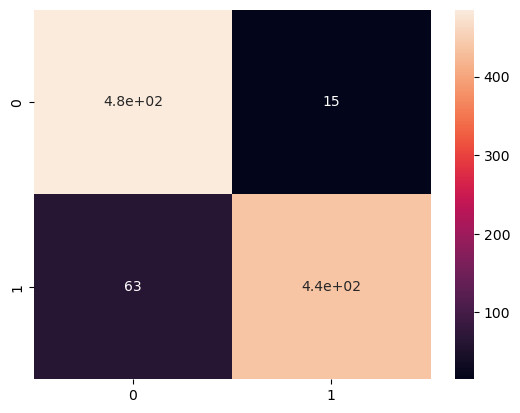

In [23]:
sns.heatmap(confusion_matrix, annot=True)

In [24]:
acc = (tp+tn)/(tp+tn+fn+fp)
print("Accuracy is: ", acc)

fnr = fn/(tp+fn)
print("False Negative Rate is: ", fnr)

precision = tp/(tp+fp)
print("Precision is : ", precision)

recall = tp/(tp+fn)
print("Recall is : ", recall)

Accuracy is:  0.922
False Negative Rate is:  0.126
Precision is :  0.96681416
Recall is :  0.874


In [27]:
model = torch.load("/Users/bytedance/Downloads/melanoma_CNN.pt")
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): AdaptiveAvgPool2d(output_size=(6, 6))
  )
  (classifier): Sequential(
    (0): Linear(in_fea

In [39]:
 history['train_loss']

[0.12701475342569843,
 0.11983110835966748,
 0.10842871410749903,
 0.11639262777537433,
 0.09474534762830303,
 0.11796254592713498,
 0.09351241309680568,
 0.07419289032143736,
 0.06637521488709008,
 0.0670731338027056]

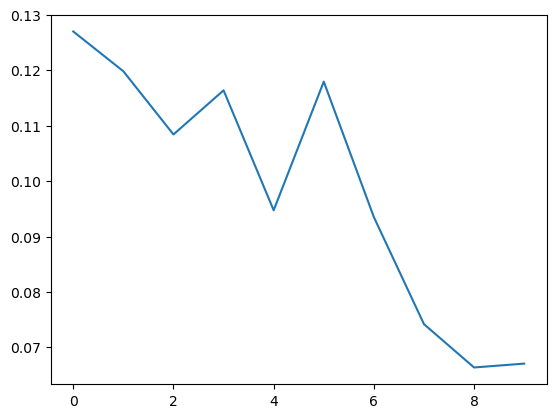

In [40]:
plt.plot(history['train_loss'])

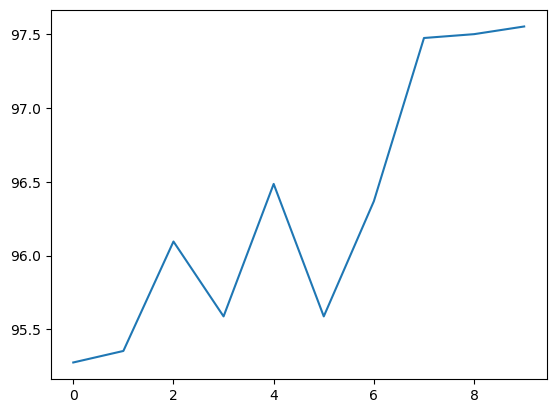

In [41]:
plt.plot(history['train_acc'])